In [1]:
# Imports
from dair_pll import file_utils
from dair_pll.multibody_learnable_system import MultibodyLearnableSystemWithTrajectory
from dair_pll.drake_experiment import MultibodyLearnableSystemConfig, MultibodyLosses
from dair_pll.multibody_terms import InertiaLearn

import torch

import cProfile, pstats, io
from pstats import SortKey
import time

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm

In [12]:
# Define System Config and System
# Note: need robot URDF with ONE finger only
learnable_config = MultibodyLearnableSystemConfig(
    urdfs={"cube": file_utils.get_asset("contactnets_cube.urdf"), 'robot': file_utils.get_asset("spherebot_lossmap.urdf")}, 
    loss=MultibodyLosses.TACTILENET_LOSS, 
    inertia_mode=InertiaLearn(mass=False, com=False, inertia=False),
    constant_bodies = ["finger_0", "finger_1"],
    w_pred  = 1e0,
    w_comp  = 1e0,
    w_diss  = 1e0,
    w_pen   = 1e0,
    w_res   = 0.,
    w_res_w = 0.,
    w_dev   = 1e5,
    do_residual=False,
    represent_geometry_as="box",
    randomize_initialization = False, 
    g_frac=1e0,
    # No additional system builders here
    use_meshcat=False,
)


learned_system = MultibodyLearnableSystemWithTrajectory(
                trajectory_model = "cube",
                traj_len = 300,
                true_traj = None,
                init_urdfs = learnable_config.urdfs,
                dt = 0.0068,
                inertia_mode = learnable_config.inertia_mode,
                constant_bodies = learnable_config.constant_bodies,
                w_pred = learnable_config.w_pred,
                w_comp = learnable_config.w_comp,
                w_diss = learnable_config.w_diss,
                w_pen = learnable_config.w_pen,
                w_res = learnable_config.w_res,
                w_res_w = learnable_config.w_res_w,
                w_dev = learnable_config.w_dev,
                output_urdfs_dir=file_utils.get_learned_urdf_dir("storage", "notebook"),
                do_residual=learnable_config.do_residual,
                represent_geometry_as=learnable_config.represent_geometry_as,
                randomize_initialization=learnable_config.randomize_initialization,
                g_frac=learnable_config.g_frac)

In [69]:
# Define Linspace of Robot Positions (X and Z), note ground is at z == 0, cube_z = 0.1, sphere_radius = 0.01
steps = 100
batch = steps * steps
robot_x_bounds = (-0.1, 0.1)
robot_z_bounds = (0.005, 0.205)
robot_x = torch.linspace(robot_x_bounds[0], robot_x_bounds[1], steps)
robot_z = torch.linspace(robot_z_bounds[0], robot_z_bounds[1], steps)
robot_q = torch.cartesian_prod(robot_x, robot_z)
robot_v = torch.zeros((batch, 2))
assert robot_q.shape == robot_v.shape == (batch, 2)

cube_q = torch.tensor([[0., 0.05, 0.]]).expand(batch, -1) # X, Z, theta
cube_v = torch.zeros((batch, 3))
assert cube_q.shape == cube_v.shape == (batch, 3)

# Concat to state
all_x = torch.hstack((cube_q, robot_q, cube_v, robot_v))

# Define empty Us batch
control = torch.zeros((batch, 2))

# Define constant force batch
lambda_m = torch.tensor([0., 0., 1.])
lambda_m_norm = torch.nn.functional.normalize(lambda_m, dim=0)
print(f"Normalized Lambda: {lambda_m_norm}")
contact_forces = {('cube_body', 'finger_0'): lambda_m_norm.expand(batch, -1)}

Normalized Lambda: tensor([0., 0., 1.])


In [70]:
# Compute Loss
# Note taking x and x_plus to be the same state
pr = cProfile.Profile()
start = time.time()
pr.enable()
loss_pred, loss_comp, loss_pen, loss_diss, loss_dev = \
                learned_system.calculate_contactnets_loss_terms(all_x, control, all_x, contact_forces)
pr.disable()
run_time = time.time() - start

> /home/ethankg/Workspace/dair_pll/dair_pll/geometry.py(789)collide_box_sphere()
-> return phi, R_AC, p_AoAc_A, p_BoBc_B


(Pdb)  c


In [71]:
# Profile and Timing
print(f"Total Run Time: {run_time}s ({run_time/batch}s per calc)")
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
profile_states = s.getvalue()

Total Run Time: 12.707051515579224s (0.0012707051515579223s per calc)


In [72]:
# Plot sum of losses, generate grid
X, Y = np.meshgrid(robot_x.numpy(), robot_z.numpy())
Z_pred = loss_pred.reshape(steps, steps).T.detach().numpy() # Matches np meshgrid location
Z_comp = loss_comp.reshape(steps, steps).T.detach().numpy() # Matches np meshgrid location
Z_pen = loss_pen.reshape(steps, steps).T.detach().numpy() # Matches np meshgrid location
Z_diss = loss_diss.reshape(steps, steps).T.detach().numpy() # Matches np meshgrid location
Z_dev = loss_dev.reshape(steps, steps).T.detach().numpy() # Matches np meshgrid location
Z_tot = learnable_config.w_pred * Z_pred + learnable_config.w_comp * Z_comp + learnable_config.w_pen * Z_pen + learnable_config.w_diss * Z_diss + learnable_config.w_dev * Z_dev
Z_geom = learnable_config.w_comp * Z_comp + learnable_config.w_pen * Z_pen + learnable_config.w_dev * Z_dev

In [73]:
# Actual Plotting
fig.clear()
ax = fig.add_subplot(111)
cmap = plt.get_cmap('YlGn')
ax.set_ylim([0.0, np.max(Y)])
ax.set_xlim([np.min(X), np.max(X)])

Z_plot = Z_tot

im = ax.pcolormesh(X, Y, Z_plot, cmap=cmap)
# Create a Rectangle patch
cube = patches.Rectangle((-0.05, 0.), 0.1, 0.1, linewidth=1, edgecolor='r', facecolor='none')
min_idx = np.argmin(Z_plot)
robot = patches.Circle((X.flatten()[min_idx], Y.flatten()[min_idx]), 0.01, linewidth=1, edgecolor='r', facecolor='none')
force = patches.Arrow(X.flatten()[min_idx], Y.flatten()[min_idx], float(lambda_m_norm[0])*0.01, float(lambda_m_norm[2])*0.01, width=0.005, linewidth=1, edgecolor='r')
# Add the patch to the Axes
ax.add_patch(cube)
ax.add_patch(robot)
ax.add_patch(force)

# Add Gradient
gradient = np.gradient(-Z_plot)
gradient_norms = np.linalg.norm(gradient,axis=0)
V, U = [np.where(gradient_norms==0,0,i/gradient_norms) for i in gradient]
ax.quiver(X, Y, U, V)
fig.colorbar(im, ax=ax)
fig.canvas.draw()

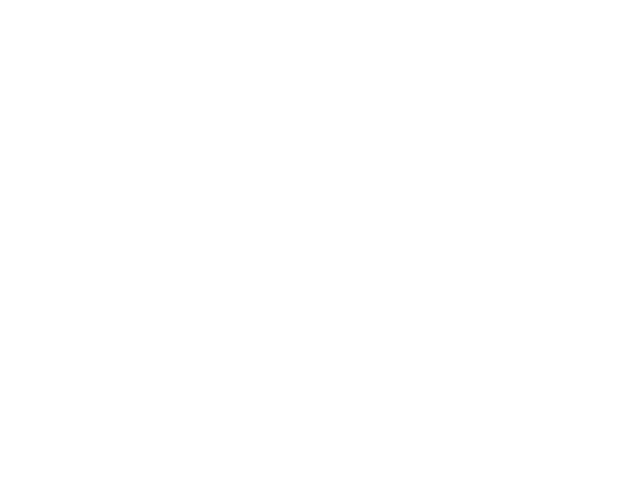

In [67]:
fig = plt.figure()

In [24]:
robot_q[4617]

tensor([-0.0071,  0.0393])

In [13]:
(X.flatten()[min_idx], Y.flatten()[min_idx])

(-0.007070707070707076, 0.03934343434343435)